In [196]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [197]:
zz = 1000
dt = 1/zz
T = 7

# Paramètres
aR = 4
aS = 4
b = 4

K = (aR/b)**3
MaxDose = 2
Ncrit = 1
Ncrifinf = Ncrit * 0.6

death_rate = 2
death_exp = 2
death_rate2 = 0.4

# Conditions initiales
n0 = 0.7
r0 = 0.07
s0 = n0 - r0

In [198]:
# Contrôle
def g(n,r,s): # classic
    if n >= Ncrifinf:
        return 1
    return 0

def soft_mtd(n):
    return 1/(math.log(K/n)+1)

def mtd(): # MTD
    return 1

def no_therapy(): # no_therapy
    return 0

# Fonctions du système d'équations différentielles
def gr(n, r):
    return (aR * n**(-1/3) - b) * r

def gs(n, c, s):
    return (aS * n**(-1/3) - b) * (1 - MaxDose*c) * s

# Méthode d'Euler
def edo(n0, r0, s0, controle):
    resN = []
    resR = []
    resS = []
    n = n0
    r = r0
    s = s0
    for i in range(zz*T):
        dr = gr(n, r)
        if controle == "classic":
            ds = gs(n, g(n,r,s), s)
        elif controle == "MTD":
            ds = gs(n, mtd(), s)
        elif controle == "no_therapy":
            ds = gs(n, no_therapy(), s)
        r = r + dt*dr
        s = s + dt*ds
        n = r + s
        resN.append(n)
        resR.append(r)
        resS.append(s)
        
        if i % zz == 0:
            #print("Au temps t = ", i/zz, ", N = ", n, ", R = ", r, ", S = ", s, "N/K = ", n/K
            pass
        
    return resN, resR, resS

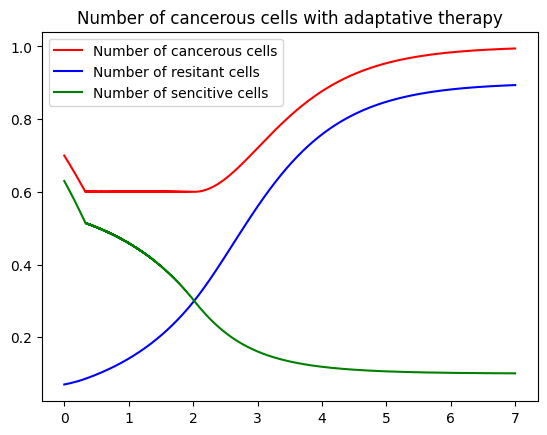

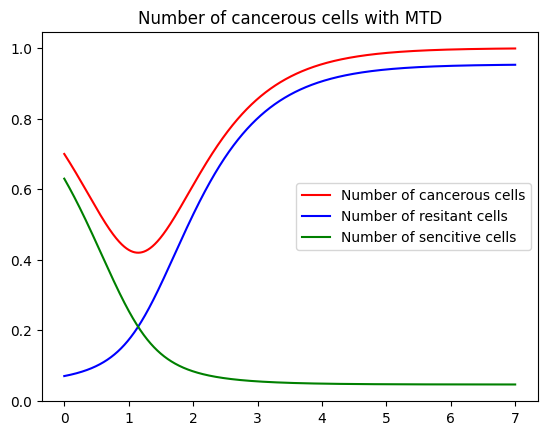

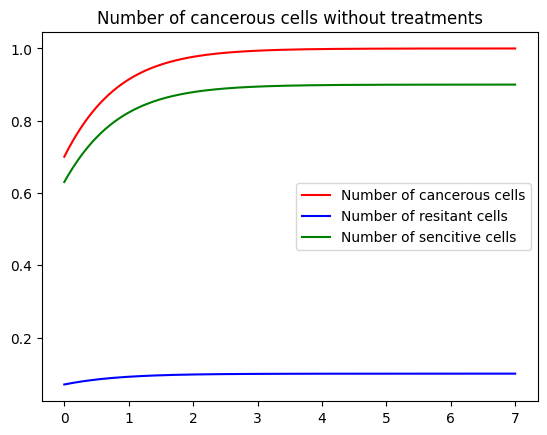

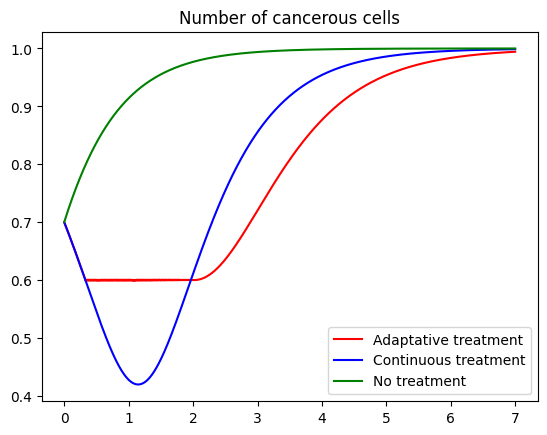

In [199]:
x = np.arange(0,T,dt)

# Adaptative treatment
evN, evR, evS = edo(n0, r0, s0, "classic")
plt.plot(x, evN, "r", label = "Number of cancerous cells")
plt.plot(x, evR, "b", label = "Number of resitant cells")
plt.plot(x, evS, "g", label = "Number of sencitive cells")
plt.legend()
plt.title("Number of cancerous cells with adaptative therapy")
plt.show()

# Maximal tolerated dose
evN_MTD, evR_MTD, evS_MTD = edo(n0, r0, s0, "MTD")
plt.plot(x, evN_MTD, "r", label = "Number of cancerous cells")
plt.plot(x, evR_MTD, "b", label = "Number of resitant cells")
plt.plot(x, evS_MTD, "g", label = "Number of sencitive cells")
plt.legend()
plt.title("Number of cancerous cells with MTD")
plt.show()

# No treatment
evN_NT, evR_NT, evS_NT = edo(n0, r0, s0, "no_therapy")
plt.plot(x, evN_NT, "r", label = "Number of cancerous cells")
plt.plot(x, evR_NT, "b", label = "Number of resitant cells")
plt.plot(x, evS_NT, "g", label = "Number of sencitive cells")
plt.legend()
plt.title("Number of cancerous cells without treatments")
plt.show()

# Total tumour burden
plt.plot(x, np.array(evN)/((aR/b)**3), "r", label = "Adaptative treatment")
plt.plot(x, np.array(evN_MTD)/((aR/b)**3), "b", label = "Continuous treatment")
plt.plot(x, np.array(evN_NT)/((aR/b)**3), "g", label = "No treatment")
plt.legend()
plt.title("Number of cancerous cells")
plt.show()

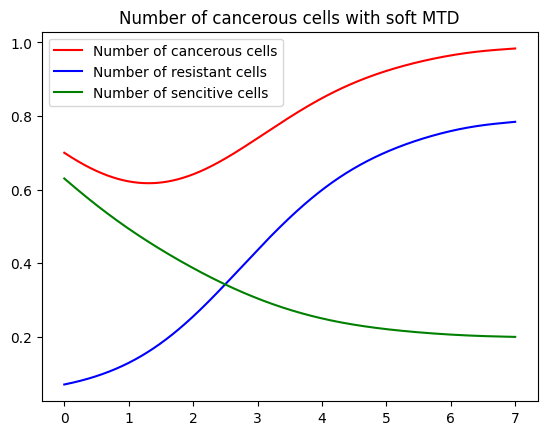

In [200]:
# Integrated solver
def dX(t,L):
    rpoint = gr(L[0], L[1])
    #spoint = gs(L[0], g(L[0], L[1], L[2]), L[2])
    spoint = gs(L[0], soft_mtd(L[0]), L[2])
    npoint = rpoint + spoint
    return npoint, rpoint, spoint

from scipy.integrate import solve_ivp
edoSolved = solve_ivp(dX, [0, T], [n0, r0, s0], method = "DOP853", t_eval = x)

plt.plot(edoSolved.t, edoSolved.y[0], "r", label = "Number of cancerous cells")
plt.plot(edoSolved.t, edoSolved.y[1], "b", label = "Number of resistant cells")
plt.plot(edoSolved.t, edoSolved.y[2], "g", label = "Number of sencitive cells")
plt.legend()
plt.title("Number of cancerous cells with soft MTD")
plt.show()

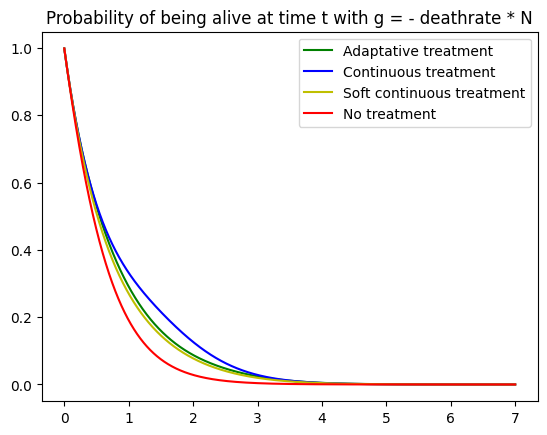

In [201]:
# Probability of being alive at time t with function g : x -> - deathrate * N
def death_curve1(evN):
    res = []
    integrale = 0
    for i in range(zz*T):
        integrale += dt*evN[i]
        prob = math.exp(- death_rate * integrale)
        res.append(prob)
    return res

plt.plot(x, death_curve1(evN), "g", label = "Adaptative treatment")
plt.plot(x, death_curve1(evN_MTD), "b", label = "Continuous treatment")
plt.plot(x, death_curve1(edoSolved.y[0]), "y", label = "Soft continuous treatment")
plt.plot(x, death_curve1(evN_NT), "r", label = "No treatment")
plt.legend()
plt.title("Probability of being alive at time t with g = - deathrate * N")
plt.show()

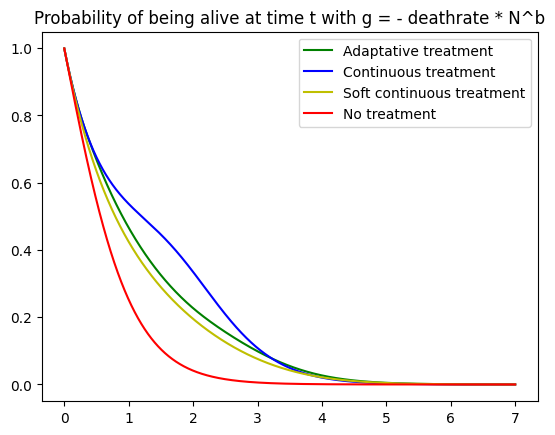

In [202]:
# Probability of being alive at time t with function g : x -> - deathrate * N^b
def death_curve2(evN):
    res = []
    integrale = 0
    for i in range(zz*T):
        integrale += dt * evN[i]**death_exp
        prob = math.exp(- death_rate * integrale)
        res.append(prob)
    return res

plt.plot(x, death_curve2(evN), "g", label = "Adaptative treatment")
plt.plot(x, death_curve2(evN_MTD), "b", label = "Continuous treatment")
plt.plot(x, death_curve2(edoSolved.y[0]), "y", label = "Soft continuous treatment")
plt.plot(x, death_curve2(evN_NT), "r", label = "No treatment")
plt.legend()
plt.title("Probability of being alive at time t with g = - deathrate * N^b")
plt.show()

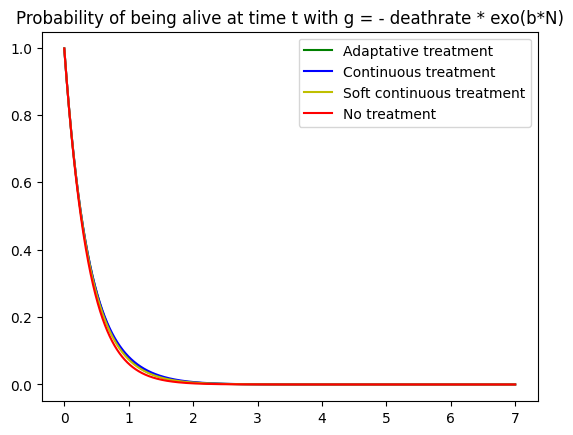

In [203]:
# Probability of being alive at time t with function g : x -> - deathrate * exo(b*N)
def death_curve3(evN):
    res = []
    integrale = 0
    for i in range(zz*T):
        integrale += dt * math.exp(death_rate2 * evN[i])
        prob = math.exp(- death_rate * integrale)
        res.append(prob)
    return res

plt.plot(x, death_curve3(evN), "g", label = "Adaptative treatment")
plt.plot(x, death_curve3(evN_MTD), "b", label = "Continuous treatment")
plt.plot(x, death_curve3(edoSolved.y[0]), "y", label = "Soft continuous treatment")
plt.plot(x, death_curve3(evN_NT), "r", label = "No treatment")
plt.legend()
plt.title("Probability of being alive at time t with g = - deathrate * exo(b*N)")
plt.show()